In [1]:

# This code is adapted on https://github.com/dome272/Diffusion-Models-pytorch, which is released under the Apache-2.0 license
# make sure you reference any code you have studied as above here

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# hyperparameters
batch_size  = 64
n_channels  = 3

dataset = 'cifar10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# optional for Colab use only - Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((64,64)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

train_iterator = iter(cycle(train_loader))

Files already downloaded and verified


Tensor Image to Plottable Image

In [3]:
def TensorToImage(img):
  img = (img.clamp(-1,1) + 1) / 2
  img = (img * 255).type(torch.uint8)
  return img

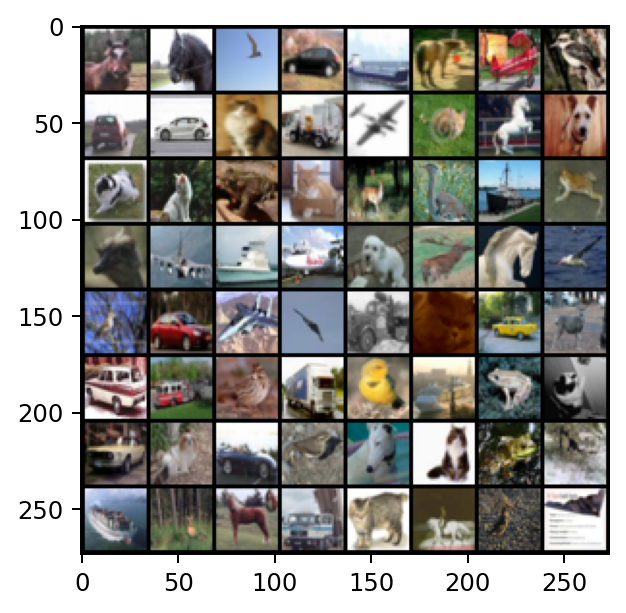

In [4]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)

x,t = x.to(device), t.to(device)
x = TensorToImage(x)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()


Diffusion Tools

In [5]:
#Diffusion Tools adapted from https://github.com/dome272/Diffusion-Models-pytorch/blob/main/ddpm.py
class Diffusion:
  def __init__(self,noise_steps=1000,beta_start=1e-4,beta_end=0.02,img_size=32,device='cuda'):
    self.noise_steps= noise_steps      #Timestep 1000 as proposed in papers
    self.beta_start = beta_start        #from practical
    self.beta_end = beta_end            #from practical
    self.img_size = img_size            #image size
    self.device = device            

    self.beta = self.prepare_noise_schedule().to(device)
    self.alpha = 1. - self.beta
    self.alpha_hat = torch.cumprod(self.alpha,dim=0)
    


  def prepare_noise_schedule(self):
    
    return torch.linspace(self.beta_start,self.beta_end,self.noise_steps)


    
  #Page 2 of https://arxiv.org/pdf/2006.11239.pdf original DDPM paper
  def noise_images(self,x,t):
    
    alpha_hat_sqrt = torch.sqrt(self.alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    one_minus_alpha_hat_sqrt = torch.sqrt(1 - self.alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    epsilon = torch.randn_like(x)
    return alpha_hat_sqrt * x + one_minus_alpha_hat_sqrt * epsilon, epsilon

  
  def sample_timesteps(self,n):
    return torch.randint(low=1,high=self.noise_steps,size = (n,))

  def LatentExploration(self,Model,latentSteps,labels):
    LatentStart = torch.randn((3,32,32)).to(self.device)
    LatentEnd = torch.randn((3,32,32)).to(self.device)
    Z = torch.zeros(latentSteps,3,32,32)
    for i in range(latentSteps):
      alpha = i / (latentSteps - 1)
      Z[i] = (1-alpha) * LatentStart + alpha * LatentEnd
    x = Z.to(self.device)

    
      
    model.eval()
    GuidanceStrength = 3
    with torch.no_grad():
      
      for i in reversed(range(1,self.noise_steps)):     #Main loop starting at max time steps ending at 1
        t = (torch.ones(latentSteps) * i).long().to(self.device)    #Tensor of length n reperesenting current time step
        PredictedNoise = Model(x,t,labels)
        
        UnconditionalPredictedNoise = Model(x,t,None)
        PredictedNoise = torch.lerp(UnconditionalPredictedNoise,PredictedNoise,GuidanceStrength)
        alpha = self.alpha[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        alpha_hat = self.alpha_hat[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        beta = self.beta[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        if i > 1:   #Only need noise for timesteps greater then 1 
          noise = torch.randn_like(x)
        else:
          noise = torch.zeros_like(x)

        
        x = 1 / torch.sqrt(alpha) * (x-((1-alpha) / (torch.sqrt(1-alpha_hat))) * PredictedNoise) + torch.sqrt(beta) * noise   #Remove noise step formula from DDPM paper
    model.train()
    x = TensorToImage(x)
    return x
  
  def sample(self,model,n,labels,InNoise=None):   #n = amount of images
    print('Sampling ' + str(n) + ' new images')
    model.eval()
    GuidanceStrength = 3
    with torch.no_grad():
      if InNoise == None:

        x = torch.randn((n,3,self.img_size,self.img_size)).to(self.device)
      else:
        x = InNoise
      for i in reversed(range(1,self.noise_steps)):     
        t = (torch.ones(n) * i).long().to(self.device)    #Tensor of length n reperesenting current time step
        PredictedNoise = model(x,t,labels)
        
        UnconditionalPredictedNoise = model(x,t,None)
        PredictedNoise = torch.lerp(UnconditionalPredictedNoise,PredictedNoise,GuidanceStrength)
        alpha = self.alpha[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        alpha_hat = self.alpha_hat[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        beta = self.beta[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        if i > 1:   #Randomly generate noise for time steps > 1 (no noise needed for timestep 0)
          noise = torch.randn_like(x)
        else:
          noise = torch.zeros_like(x)

        
        x = 1 / torch.sqrt(alpha) * (x-((1-alpha) / (torch.sqrt(1-alpha_hat))) * PredictedNoise) + torch.sqrt(beta) * noise   #Remove noise step formula from DDPM paper
    model.train()
    x = TensorToImage(x)
    return x

tensor([[[[ 1.7314,  1.2398, -1.6286,  ...,  1.1789, -1.0139, -1.9610],
          [-1.3313, -0.1116,  0.9595,  ...,  1.2866, -0.2520, -0.8536],
          [-1.9041, -0.6312, -1.4498,  ..., -0.6919,  0.5233,  0.4259],
          ...,
          [ 0.3874, -0.6959, -1.5809,  ...,  0.4571,  1.3460, -1.7526],
          [-0.1708, -0.5150,  0.5843,  ...,  1.6791, -0.0089,  0.4686],
          [ 0.2467,  1.1765,  0.8001,  ...,  1.0464,  1.6780,  1.9824]],

         [[-0.1725, -1.0721,  2.4620,  ...,  0.4024, -0.4461,  0.9462],
          [-1.4377,  0.9164, -0.1291,  ..., -1.0941, -0.2871,  0.2506],
          [-0.5748,  0.6317,  0.4363,  ...,  1.6701,  1.8582, -1.0635],
          ...,
          [ 0.1497, -0.7671, -0.9975,  ...,  0.5630, -0.4753, -1.1258],
          [ 0.7331, -0.4629, -0.1011,  ..., -0.2680,  0.2414, -0.7798],
          [-0.3764,  1.1679, -1.4453,  ...,  0.2882,  1.3226,  1.5219]],

         [[ 0.0918, -0.2838, -0.0646,  ..., -1.3998,  1.5686, -1.6915],
          [-1.4080, -0.8608,  

Make UNET !

In [6]:
#U-Net Code adapted from https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):

  def __init__(self, in_channels, out_channels, emb_dim=256):

      super().__init__()
      self.maxpool_conv = nn.Sequential(
          nn.MaxPool2d(2),
          DoubleConv(in_channels, in_channels, residual=True),
          DoubleConv(in_channels, out_channels),
      )

      self.emb_layer = nn.Sequential(
          nn.SiLU(),
          nn.Linear(
              emb_dim,
              out_channels
            ),
        )

  def forward(self, x, t):
      x = self.maxpool_conv(x)
      emb = self.emb_layer(t).unsqueeze(2).unsqueeze(3).repeat(1, 1, x.shape[-2], x.shape[-1])
      return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t).unsqueeze(2).unsqueeze(3).repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class SelfAttention(nn.Module):

    def __init__(self, channels):

        super(SelfAttention, self).__init__()
        self.channels = channels        
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None):
        super().__init__()
        if num_classes != None:
            self.label_emb = nn.Embedding(num_classes, time_dim)
        self.time_dim = time_dim
        self.inConvolution = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)

        

        self.bot1 = DoubleConv(256, 256)
    
        self.bot2 = DoubleConv(256, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outConvolution = nn.Conv2d(64, c_out, kernel_size=1)
    

    


        
    def SinusoidalPositionEmbedding(self, t, channels):    #Sinusoidal position encoding as seen in Attention is all you need https://arxiv.org/pdf/1706.03762.pdf

      device = t.device
      inv_freq = 1.0 / (
          10000
          ** (torch.arange(0, channels, 2, device=device).float() / channels)
      )
      SinEncoding = torch.sin(t.repeat(1, channels // 2) * inv_freq)
      CosineEncoding = torch.cos(t.repeat(1, channels // 2) * inv_freq)
      
      return torch.cat([SinEncoding, CosineEncoding], dim=-1) 
    def forward(self, x, t, y=None):

        t = self.SinusoidalPositionEmbedding(t.unsqueeze(-1), self.time_dim)

        if y is not None:
            t += self.label_emb(y)
        x1 = self.inConvolution(x)    #->64
        x2 = self.down1(x1, t)   #->128
        x2 = self.sa1(x2)    #->128
        x3 = self.down2(x2, t)  #
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outConvolution(x)
        return output
        
    
    


In [7]:

from PIL import Image
def save_images(images,path,**kwargs):
  grid = torchvision.utils.make_grid(images,**kwargs)
  ndarr = grid.permute(1,2,0).to("cpu").numpy()
  im = Image.fromarray(ndarr)
  im.save(path)



In [8]:

import os
def train(num_classes,epochs,image_size,learning_rate = 1e-3,resume=False):
  device = 'cuda'

  diffusion = Diffusion(img_size = image_size,device = device)
  model = UNet_conditional(num_classes=num_classes).to(device)
  mse = nn.MSELoss()
  start = 1
  optimizer =  torch.optim.AdamW(model.parameters(),lr=learning_rate)

  if resume:
    checkpoint = torch.load(f'drive/MyDrive/NewDeepLearningModels/ckpt.pt')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start = checkpoint['epoch']
    
    
  for epoch in range(start,epochs):
    print(epoch)
    for i, (images,labels) in enumerate(train_loader):

      images = images.to(device)
      labels = labels.to(device)
      
      
      t = diffusion.sample_timesteps(images.shape[0]).to(device)
      x_t, noise = diffusion.noise_images(images,t)

      if np.random.random() < 0.1:    #10% of the time unconditional training from CFG paper
        labels = None
      predicted_noise = model(x_t,t,labels)
      loss = mse(noise,predicted_noise)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
     
    # Checkpoint = {'epoch':epoch+1,'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
    # torch.save(Checkpoint,os.path.join("drive/MyDrive/NewDeepLearningModels",f"ckpt{epoch}.pt"))
    if epoch % 5 == 0:

      #sampled_images = diffusion.sample(model,n=images.shape[0],labels=labels)
      sampled_images = diffusion.sample(model,n=batch_size,labels=labels)
      plt.rcParams['figure.dpi'] = 175
      plt.grid(False)
      plt.imshow(torchvision.utils.make_grid(sampled_images).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
      plt.show()
      plt.pause(0.0001)
      save_images(sampled_images,os.path.join("drive/MyDrive/NewDeepLearningSamples",f"{epoch}.jpg"))
      Checkpoint = {'epoch':epoch+1,'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
      torch.save(Checkpoint,os.path.join("drive/MyDrive/NewDeepLearningModels",f"ckpt.pt"))
    
      
      
train(10,5000,32)
      



1


KeyboardInterrupt: ignored

Code to get a random sample of 64 

In [9]:
diffusion = Diffusion(img_size = 32,device = device)
model = UNet_conditional(num_classes=10).to(device)
checkpoint = torch.load(f'drive/MyDrive/NewDeepLearningModels/ckpt.pt')
x,t = next(train_iterator)
t=t.to('cuda')
model.load_state_dict(checkpoint['state_dict'])
Sample = diffusion.sample(model,64,t)
plt.rcParams['figure.dpi'] = 135
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(Sample).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.pause(0.0001)


Sampling 64 new images


KeyboardInterrupt: ignored

Code to get a 10x10 linear interpolation

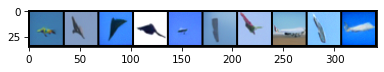

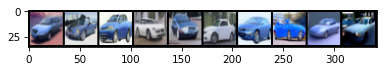

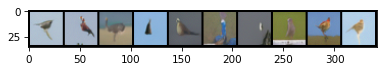

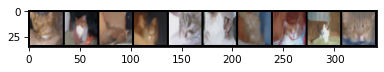

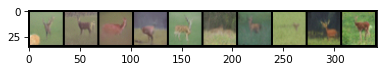

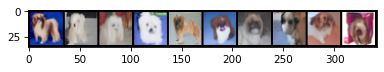

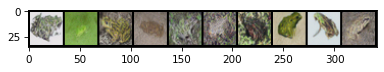

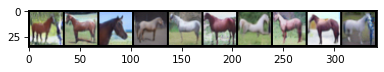

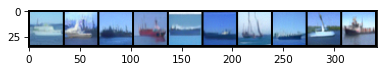

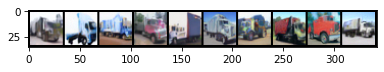

In [145]:
diffusion = Diffusion(img_size = 32,device = device)
model = UNet_conditional(num_classes=10).to(device)
checkpoint = torch.load(f'drive/MyDrive/NewDeepLearningModels/ckpt.pt')
model.load_state_dict(checkpoint['state_dict'])
test = torch.randint(low=0,high=9,size=[64])
FullImages = torch.Tensor(100,3,32,32).to('cuda')

for i in range(10):


  Labels = torch.zeros(10)
  Labels.fill_(i)
  Labels = Labels.int()
  Labels = Labels.to('cuda')
  Images = diffusion.LatentExploration(model,10,Labels)
  
  plt.rcParams['figure.dpi'] = 75
  plt.grid(False)
  plt.imshow(torchvision.utils.make_grid(Images,nrow=10).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.show()

In [141]:
diffusion = Diffusion(img_size = 32,device = device)
model = UNet_conditional(num_classes=10).to(device)
checkpoint = torch.load(f'drive/MyDrive/NewDeepLearningModels/ckpt.pt')
x = torch.randn((3,32,self.img_size)).to(self.device)


tensor([1, 1], dtype=torch.int32)


KeyboardInterrupt: ignored

In [42]:

x = torch.randn((n,3,self.img_size,self.img_size)).to(self.device)


AttributeError: ignored